# Тема 4. Центральная предельная теорема

In [1]:
import numpy as np
import math as mt
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
np.random.seed(42)

### Задание 1

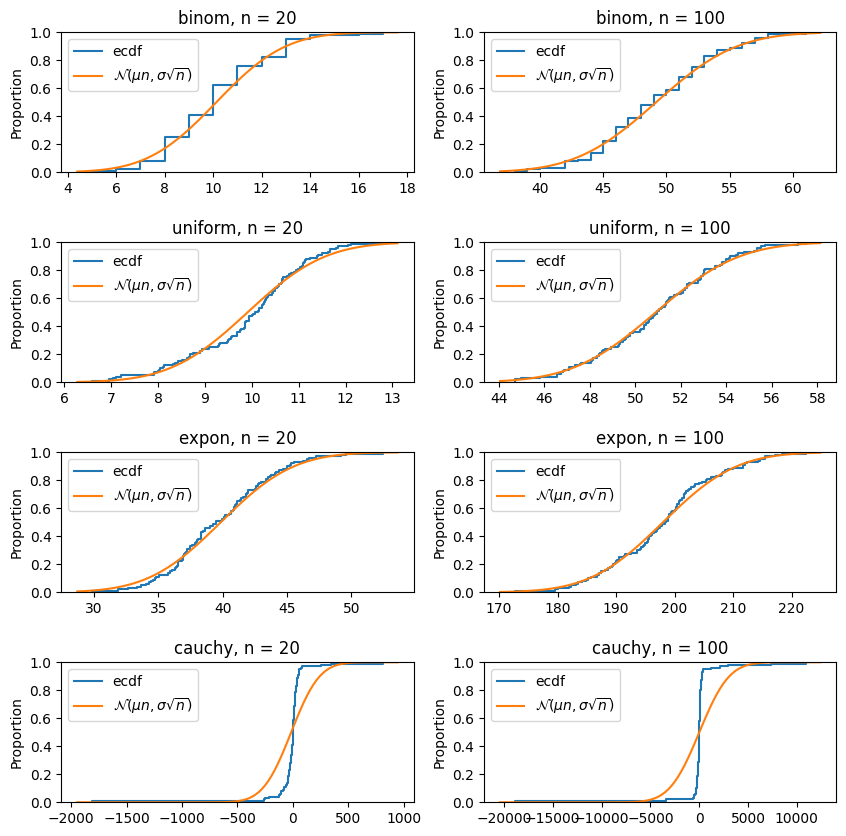

In [3]:
m = 100
sample_sizes = (20, 100)
distributions = (
    st.binom(1, 0.5),
    st.uniform(0, 1),
    st.expon(1),
    st.cauchy()
)

fig, axes = plt.subplots(len(distributions), len(sample_sizes), figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for i, rv in enumerate(distributions):
    for j, n in enumerate(sample_sizes):
        samples = rv.rvs((m, n))
        sums = np.sum(samples, axis=1)
        ax = axes[i, j]
        sns.ecdfplot(sums, ax=ax, label='ecdf')
        x = np.linspace(*ax.get_xlim(), 100)
        y = st.norm.cdf(x, n * samples.mean(), mt.sqrt(n) * samples.std())
        ax.plot(x, y, label=r"$\mathcal{N}(\mu n, \sigma \sqrt{n})$")
        ax.set_title(f'{rv.dist.name}, n = {n}')
        ax.legend()

### Задание 2

$X \sim Gamma(k,\theta)$. Построить на одном графике плотность распределения сл.в. $Y = \frac{X - EX}{\sqrt{DX}}$ и плотность $\mathcal{N}(0,1)$ для различных k.

$$Y = \frac{X - a}{b} \iff X = b Y + a$$ 
$$p_Y(x) = |b| p_X(b x + a) $$
В нашем случае $a = k \theta$ и $b = \sqrt{k} \theta$.

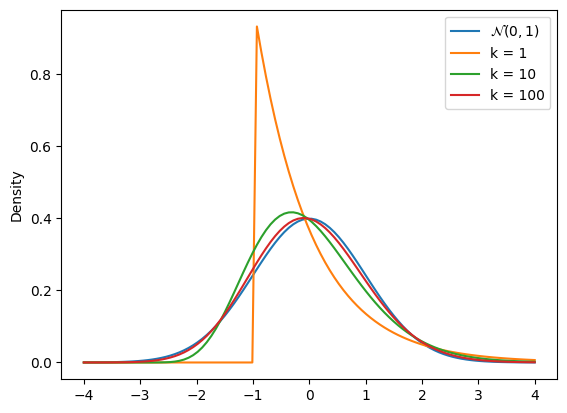

In [4]:
theta = 4
Ks = (1, 10, 100)

fig = plt.figure()
ax = fig.add_subplot()

x = np.linspace(-4, 4, 100)
ax.set_ylabel("Density")
ax.plot(x, st.norm.pdf(x), label=r"$\mathcal{N}(0,1)$")

for k in Ks:
    a = k * theta
    b = mt.sqrt(k) * theta
    y = abs(b) * st.gamma.pdf(b * x + a, a=k, scale=theta)
    ax.plot(x, y, label=f"k = {k}")

ax.legend();

### Задание 3

Построить гистограмму $S_n = X_1 + \ldots + X_n - \mu n$ для $X_i \sim Geom(p)$ и $X_i \sim Gamma(a,b)$

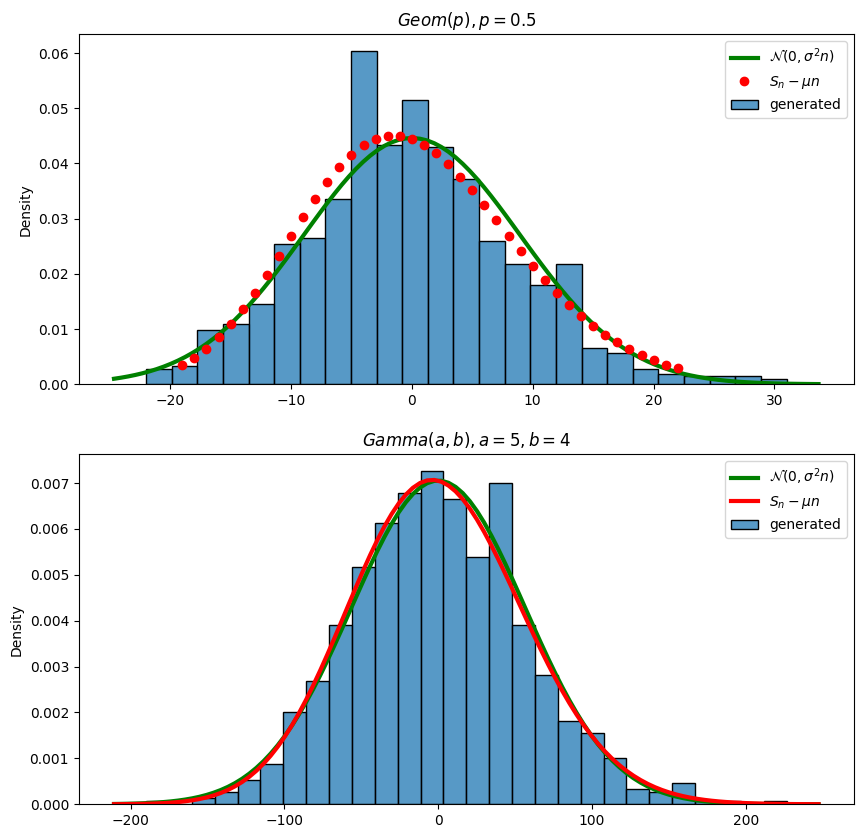

In [5]:
n = 40
k = 1000
p = 0.5
a, b = 5, 4

Task = namedtuple('Task', ['name', 'rv', 'sum'])
tasks = (
    Task(
        fr"$Geom(p), p={p}$",
        st.geom(p, loc=-1),
        st.nbinom(n, p)
    ),
    Task(
        fr"$Gamma(a, b), a={a}, b={b}$",
        st.gamma(a=a, scale=b),
        st.gamma(a=a*n, scale=b)
    )
)

fig, axes = plt.subplots(len(tasks), 1, figsize=(10, 10))

for ax, task in zip(axes, tasks):
    mu, var = task.rv.stats()
    std = mt.sqrt(var)
    samples = task.rv.rvs((k, n))
    sums = np.sum(samples, axis=1)
    sns.histplot(sums - mu * n, stat='density', ax=ax, label="generated")
    x = np.linspace(*ax.get_xlim(), 100)
    y = st.norm.pdf(x, 0, mt.sqrt(n) * std)
    ax.plot(x, y, c='g', lw=3, label=r"$\mathcal{N}(0,\sigma^2 n)$")
    if isinstance(task.sum.dist, st.rv_discrete):
        x = np.arange(task.sum.ppf(0.01), task.sum.ppf(0.99))
        y = task.sum.pmf(x)
        ax.plot(x - mu * n, y, 'ro', label=r"$S_n - \mu n$")
    else:
        y = task.sum.pdf(x + mu * n)
        ax.plot(x, y, c='r', lw=3, label="$S_n - \mu n$")
    ax.set_title(task.name)
    ax.legend()


### Задание 4

$Y = \frac{X - EX}{\sqrt{DX}}$

In [6]:
def BE(acm3, std, n):
    C = 0.4784
    return C * acm3 / (mt.sqrt(n) * std**3)


def asympt(x, skewness, n):
    return skewness / (6 * mt.sqrt(n)) * (1 - x**2) * st.norm.pdf(x)

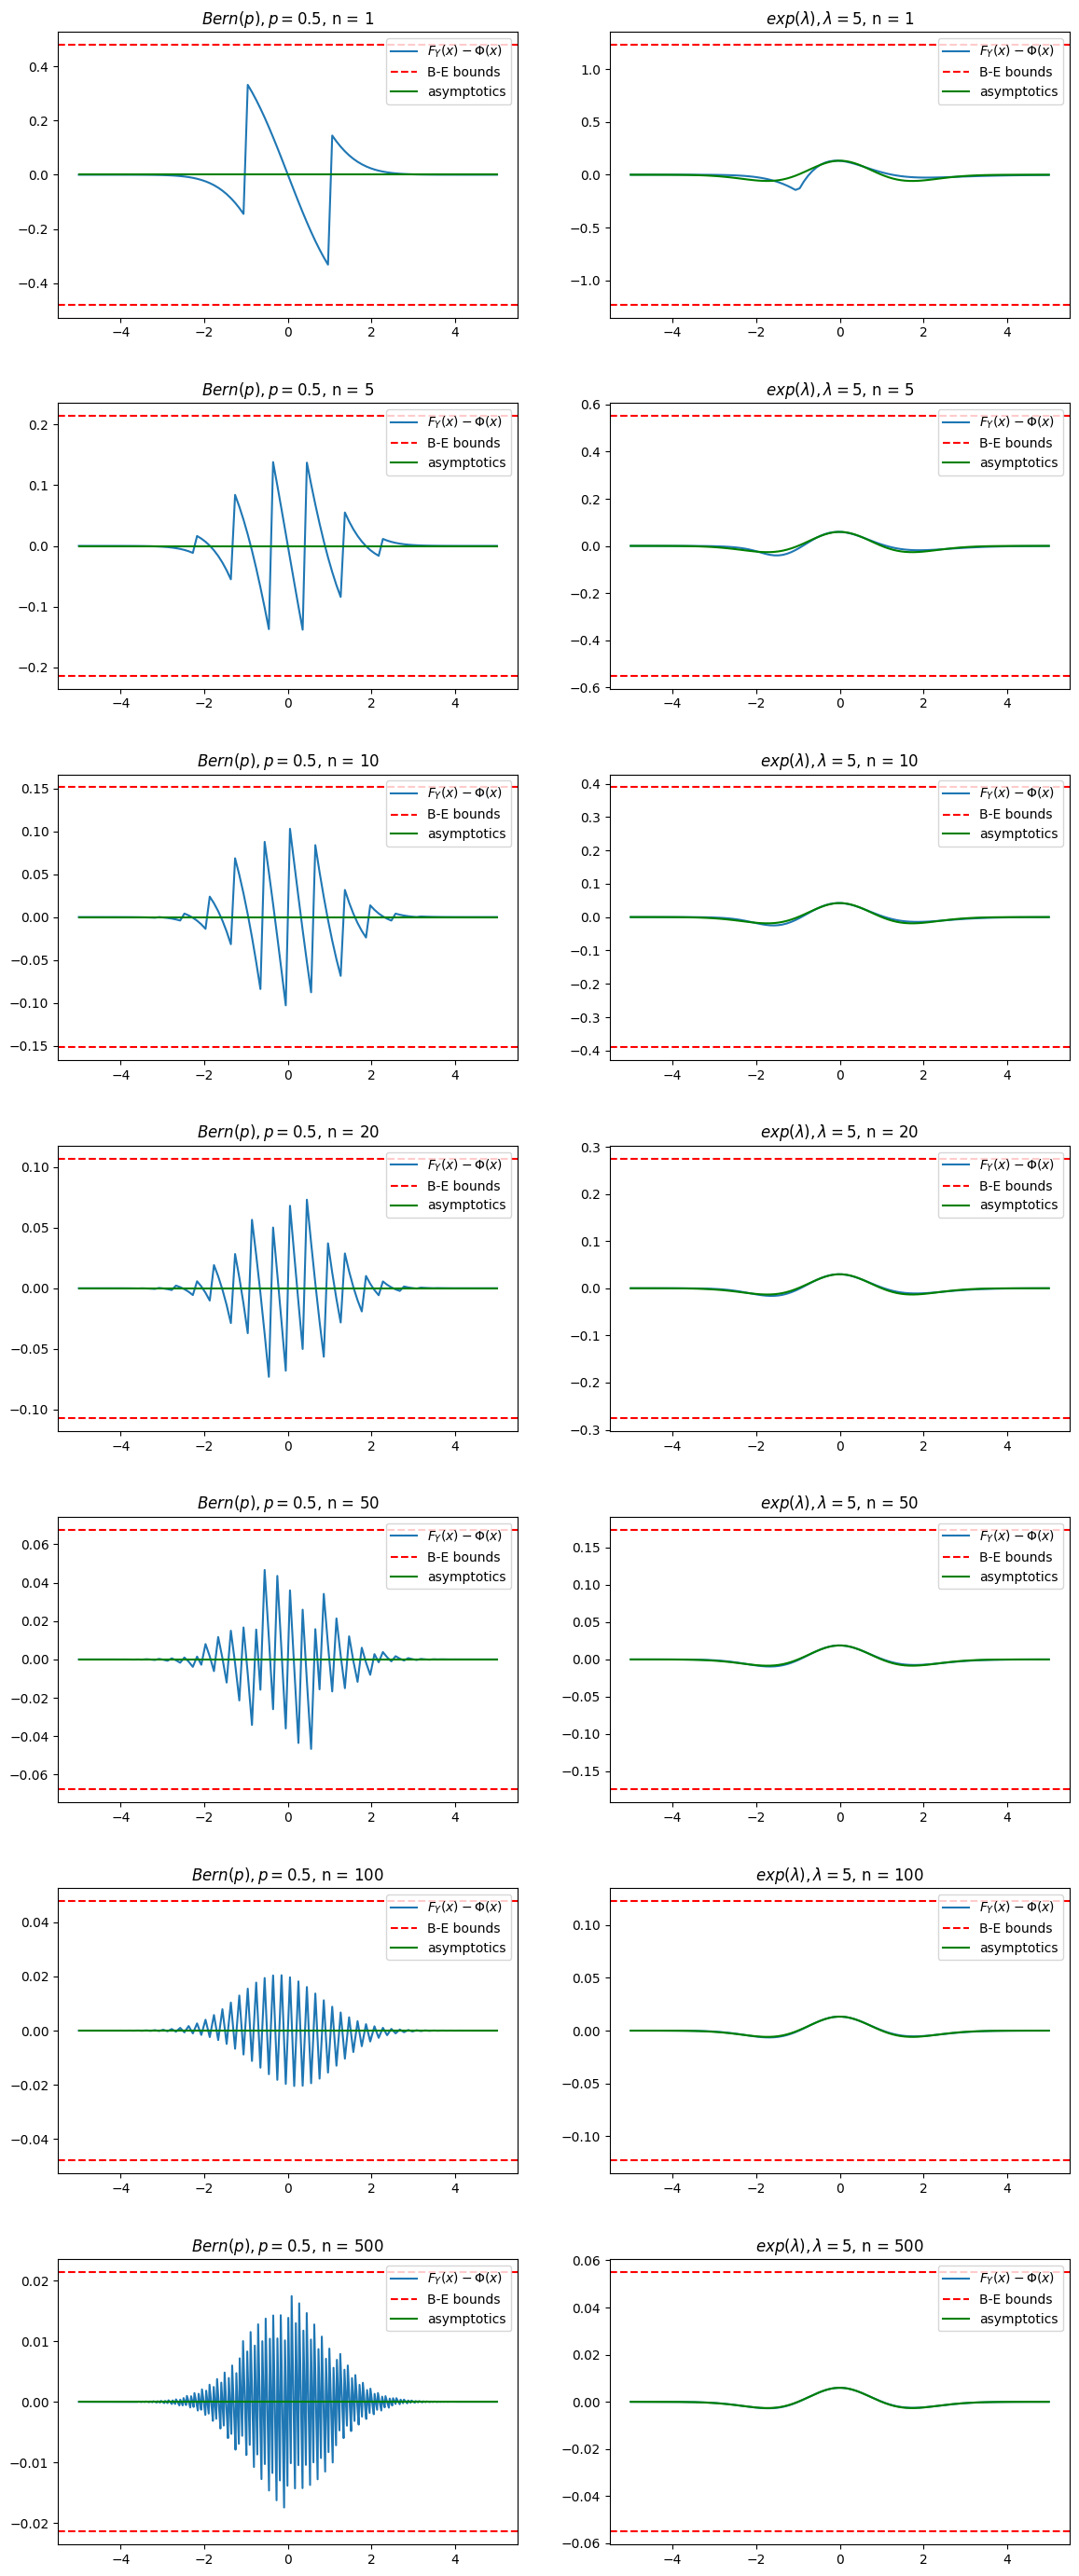

In [8]:
Ns = (1, 5, 10, 20, 50, 100, 500)

p = 0.5
a = 5
Task = namedtuple('Task', ['name', 'rv', 'acm3', 'sum'])
tasks = [
    Task(
        fr"$Bern(p), p = {p}$",
        st.binom(1, p),
        (1 - p)**3 * p + p**3 * (1 - p),
        lambda n, p=p: st.binom(n, p)
    ),
    Task(
        fr"$exp(\lambda), \lambda = {a}$",
        st.expon(scale=1/a),
        None,
        lambda n, a=a: st.gamma(a=n, scale=1/a)
    )
]

for i, task in enumerate(tasks):
    if task.acm3 is None:
        aux = task.rv.rvs(1000)
        aux = np.abs(aux - aux.mean())
        tasks[i] = task._replace(acm3=np.mean(aux**3))

width, height = len(tasks) * 7, len(Ns) * 5
fig, axes = plt.subplots(len(Ns), len(tasks), figsize=(width, height))
fig.subplots_adjust(hspace=0.3)

for j, task in enumerate(tasks):
    for i, n in enumerate(Ns):
        ax = axes[i, j]
        mu, var, sk = task.rv.stats('mvs')
        std = mt.sqrt(var)
        x = np.linspace(-5, 5, max(n, 100))
        a = mu * n
        b = mt.sqrt(n) * std
        y = (task.sum(n)).cdf(b * x + a) - st.norm.cdf(x)
        ax.plot(x, y, label=r"$F_Y(x) - \Phi(x)$")
        ax.axhline(BE(task.acm3, std, n), c='r', ls='--', label="B-E bounds")
        ax.axhline(-BE(task.acm3, std, n), c='r', ls='--')
        y = asympt(x, sk, n)
        ax.plot(x, y, c='g', label="asymptotics")
        ax.set_title(f"{task.name}, n = {n}")
        ax.legend()